In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/UBC-OCEAN/updated_image_ids.json
/kaggle/input/UBC-OCEAN/sample_submission.csv
/kaggle/input/UBC-OCEAN/train.csv
/kaggle/input/UBC-OCEAN/test.csv
/kaggle/input/UBC-OCEAN/test_thumbnails/41_thumbnail.png
/kaggle/input/UBC-OCEAN/train_images/14127.png
/kaggle/input/UBC-OCEAN/train_images/34649.png
/kaggle/input/UBC-OCEAN/train_images/15221.png
/kaggle/input/UBC-OCEAN/train_images/52375.png
/kaggle/input/UBC-OCEAN/train_images/17487.png
/kaggle/input/UBC-OCEAN/train_images/32112.png
/kaggle/input/UBC-OCEAN/train_images/22290.png
/kaggle/input/UBC-OCEAN/train_images/48734.png
/kaggle/input/UBC-OCEAN/train_images/39146.png
/kaggle/input/UBC-OCEAN/train_images/64950.png
/kaggle/input/UBC-OCEAN/train_images/32042.png
/kaggle/input/UBC-OCEAN/train_images/63429.png
/kaggle/input/UBC-OCEAN/train_images/13526.png
/kaggle/input/UBC-OCEAN/train_images/53859.png
/kaggle/input/UBC-OCEAN/train_images/63836.png
/kaggle/input/UBC-OCEAN/train_images/56117.png
/kaggle/input/UBC-OCEAN/train_i

In [2]:
!pip install torch torchvision torchaudio
!pip install --upgrade torch torchvision torchaudio


import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt
from PIL import Image

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
import torchvision.transforms as transforms

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/96/82/0966469ded5946cb4c18dd11b04eac78c943269fc79d290740d6477005e8/torch-2.1.1-cp310-cp310-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/a3/73/1aa7a38ec9b20ebc55bd6ac70c6c134333933c3be4572e4885d609cd1625/torchvision-0.16.1-cp310-cp310-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for torchaudio from https://files.pythonhosted.org/packages/2a/58/18754a3e193ba5fb6097830d51b788574c43ed30f9adf8106cdfd5315ad1/torchaudio-2.1.1-cp310-cp310-manylinux1_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 59.6 MB/s eta 0:00:00
  Obtaining dependency information for nvidia-cudnn-cu12==8.9.2.26 from https://files.pythonhosted

In [3]:
CONFIG = {
    "seed": 30,
    "epochs": 30,
    "img_size": 400,
    "model_name": "tf_efficientnet_b0_ns",
    "checkpoint_path" : "/kaggle/input/tf-efficientnet/pytorch/tf-efficientnet-b0/1/tf_efficientnet_b0_aa-827b6e33.pth",
    "num_classes": 8,
    "train_batch_size": 32,
    "valid_batch_size": 64,
    "learning_rate": 1e-4,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 500,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

In [4]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [5]:
ROOT_DIR = '/kaggle/input/UBC-OCEAN'
TRAIN_DIR = '/kaggle/input/UBC-OCEAN/train_thumbnails'
TEST_DIR = '/kaggle/input/UBC-OCEAN/test_images'

In [6]:
def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}_thumbnail.png"

In [7]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.png"))

In [8]:
df = pd.read_csv(f"{ROOT_DIR}/train.csv")
df['file_path'] = df['image_id'].apply(get_train_file_path)
df = df[ df["file_path"].isin(train_images) ].reset_index(drop=True)
df

,image_id,label,image_width,image_height,is_tma,file_path
0,4,HGSC,23785,20008,False,/kaggle/input/UBC-OCEAN/train_thumbnails/4_thu...
1,66,LGSC,48871,48195,False,/kaggle/input/UBC-OCEAN/train_thumbnails/66_th...
2,281,LGSC,42309,15545,False,/kaggle/input/UBC-OCEAN/train_thumbnails/281_t...
3,286,EC,37204,30020,False,/kaggle/input/UBC-OCEAN/train_thumbnails/286_t...
4,431,HGSC,39991,40943,False,/kaggle/input/UBC-OCEAN/train_thumbnails/431_t...
...,...,...,...,...,...,...
508,65022,LGSC,53355,46675,False,/kaggle/input/UBC-OCEAN/train_thumbnails/65022...
509,65094,MC,55042,45080,False,/kaggle/input/UBC-OCEAN/train_thumbnails/65094...
510,65300,HGSC,75860,27503,False,/kaggle/input/UBC-OCEAN/train_thumbnails/65300...
511,65371,HGSC,42551,41800,False,/kaggle/input/UBC-OCEAN/train_thumbnails/65371...


In [9]:
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['label'])

with open("label_encoder.pkl", "wb") as fp:
    joblib.dump(encoder, fp)

In [10]:
CONFIG['T_max'] = df.shape[0] * (CONFIG["n_fold"]-1) * CONFIG['epochs'] // CONFIG['train_batch_size'] // CONFIG["n_fold"]
CONFIG['T_max']

384

In [11]:
skf = StratifiedKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(skf.split(X=df, y=df.label)):
      df.loc[val_ , "kfold"] = int(fold)

In [12]:
class UBCDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df['label'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.labels[index]
        
        # Convert the NumPy array to a PIL Image
        img = Image.fromarray(img)
        
        if self.transforms:
            img = self.transforms(img)
            
            
        return {
            'image': img,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [13]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(), 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)) # mean and std
])

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64) # normalize the activations of each layer

        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(64)

        self.conv6 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.conv7 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(128)
        self.shortcut1 = nn.Sequential(
                nn.Conv2d(64, 128, 1, padding=0, bias=False),
                nn.BatchNorm2d(128)
        )
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv8 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        self.conv9 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn9 = nn.BatchNorm2d(128)

        self.conv10 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn10 = nn.BatchNorm2d(128)
        self.conv11 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn11 = nn.BatchNorm2d(128)

        self.conv12 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn12 = nn.BatchNorm2d(256)
        self.conv13 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn13 = nn.BatchNorm2d(256)
        self.shortcut2 = nn.Sequential(
                nn.Conv2d(128, 256, 1, padding=0, bias=False),
                nn.BatchNorm2d(256)
        )
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv14 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn14 = nn.BatchNorm2d(256)
        self.conv15 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn15 = nn.BatchNorm2d(256)

        self.conv16 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn16 = nn.BatchNorm2d(256)
        self.conv17 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn17 = nn.BatchNorm2d(256)

        self.conv18 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn18 = nn.BatchNorm2d(512)
        self.conv19 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn19 = nn.BatchNorm2d(512)
        self.shortcut3 = nn.Sequential(
                nn.Conv2d(256, 512, 1, padding=0, bias=False),
                nn.BatchNorm2d(512)
        )

        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv20 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn20 = nn.BatchNorm2d(512)
        self.conv21 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn21 = nn.BatchNorm2d(512)

        self.conv22 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn22 = nn.BatchNorm2d(512)
        self.conv23 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn23 = nn.BatchNorm2d(512)

        self.conv24 = nn.Conv2d(512, 1024, 3, padding=1)
        self.bn24 = nn.BatchNorm2d(1024)
        self.conv25 = nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn25 = nn.BatchNorm2d(1024)
        self.shortcut4 = nn.Sequential(
                nn.Conv2d(512, 1024, 1, padding=0, bias=False),
                nn.BatchNorm2d(1024))
        self.pool4 = nn.AvgPool2d(4, 4)

        self.fc_net = nn.Linear(1024, CONFIG['num_classes']) 

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        '''
        x = self.pool(F.relu(self.conv1(x)))
        # Output size = 28//2 x 28//2 = 14 x 14

        x = self.pool(F.relu(self.conv2(x)))
        # Output size = 10//2 x 10//2 = 5 x 5

        x = x.view(-1, 16 * 5 * 5)
        x = self.fc_net(x)
        '''
        # print('316:', x.size())
        x = F.relu(self.bn1(self.conv1(x)))

        tempx = F.relu(self.bn2(self.conv2(x)))
        tempx = F.relu(self.bn3(self.conv3(tempx)))
        x = tempx + x # Residual connections allow gradients to flow more easily during training, mitigating the vanishing gradient problem in deep networks
        # print('322:', x.size())

        tempx = F.relu(self.bn4(self.conv4(x)))
        tempx = F.relu(self.bn5(self.conv5(tempx)))
        x = tempx + x
        # print('327:', x.size())

        tempx = F.relu(self.bn6(self.conv6(x)))
        tempx = F.relu(self.bn7(self.conv7(tempx)))
        x = tempx + self.shortcut1(x)
        x = self.pool1(x)
        # print('333:', x.size())

        tempx = F.relu(self.bn8(self.conv8(x)))
        tempx = F.relu(self.bn9(self.conv9(tempx)))
        x = tempx + x
        # print('338:', x.size())

        tempx = F.relu(self.bn10(self.conv10(x)))
        tempx = F.relu(self.bn11(self.conv11(tempx)))
        x = tempx + x
        # print('343:', x.size())

        tempx = F.relu(self.bn12(self.conv12(x)))
        tempx = F.relu(self.bn13(self.conv13(tempx)))
        x = tempx + self.shortcut2(x)
        x = self.pool2(x)
        # print('349:', x.size())

        tempx = F.relu(self.bn14(self.conv14(x)))
        tempx = F.relu(self.bn15(self.conv15(tempx)))
        x = tempx + x
        # print('354:', x.size())

        tempx = F.relu(self.bn16(self.conv16(x)))
        tempx = F.relu(self.bn17(self.conv17(tempx)))
        x = tempx + x
        # print('359:', x.size())

        tempx = F.relu(self.bn18(self.conv18(x)))
        tempx = F.relu(self.bn19(self.conv19(tempx)))
        x = tempx + self.shortcut3(x)
        x = self.pool3(x)
        # print('365:', x.size())

        tempx = F.relu(self.bn20(self.conv20(x)))
        tempx = F.relu(self.bn21(self.conv21(tempx)))
        x = tempx + x
        # print('370:', x.size())

        tempx = F.relu(self.bn22(self.conv22(x)))
        tempx = F.relu(self.bn23(self.conv23(tempx)))
        x = tempx + x
        # print('375:', x.size())

        tempx = F.relu(self.bn24(self.conv24(x)))
        tempx = F.relu(self.bn25(self.conv25(tempx)))
        x = tempx + self.shortcut4(x)
        # print('380:', x.size())
        x = self.pool4(x)
        # print('382:', x.size())

        x = x.view(x.size(0), -1)
        # print('385:', x.size())
        x = self.fc_net(x)
        # print('387:', x.size())

        return x


# Move the model to the GPU if available
model = Net().to(CONFIG["device"])

In [15]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [16]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    running_acc  = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        labels = data['label'].to(device, dtype=torch.long)
        
        batch_size = images.size(0)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss = loss / CONFIG['n_accumulate']
            
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        _, predicted = torch.max(torch.softmax(outputs, dim=1), 1)  # Apply softmax here
        acc = torch.sum(predicted == labels)
        
        running_loss += (loss.item() * batch_size)
        running_acc += acc.item()
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_acc = running_acc / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_Acc=epoch_acc,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss, epoch_acc

In [17]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_acc = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        images = data['image'].to(device, dtype=torch.float)
        labels = data['label'].to(device, dtype=torch.long)
        
        batch_size = images.size(0)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(model.softmax(outputs), 1)
        acc = torch.sum( predicted == labels )

        running_loss += (loss.item() * batch_size)
        running_acc  += acc.item()
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_acc = running_acc / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_Acc=epoch_acc,
                        LR=optimizer.param_groups[0]['lr'])   
    
    gc.collect()
    
    return epoch_loss, epoch_acc

In [18]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_acc = -np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss, train_epoch_acc = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, val_epoch_acc = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Train Accuracy'].append(train_epoch_acc)
        history['Valid Accuracy'].append(val_epoch_acc)
        history['lr'].append( scheduler.get_lr()[0] )
        
        # deep copy the model
        if best_epoch_acc <= val_epoch_acc:
            print(f"{b_}Validation Accuracy Improved ({best_epoch_acc} ---> {val_epoch_acc})")
            best_epoch_acc = val_epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "Acc{:.2f}_Loss{:.4f}_epoch{:.0f}.bin".format(best_epoch_acc, val_epoch_loss, epoch)
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Accuracy: {:.4f}".format(best_epoch_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = UBCDataset(df_train, transforms=transform)
    valid_dataset = UBCDataset(df_valid, transforms=transform)

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=1, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=1, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [19]:
train_loader, valid_loader = prepare_loaders(df, fold=CONFIG["fold"])


In [20]:
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])
scheduler = fetch_scheduler(optimizer)

In [21]:
model, history = run_training(model, optimizer, scheduler,
                              device=CONFIG['device'],
                              num_epochs=CONFIG['epochs'])

100%|██████████| 2/2 [00:28<00:00, 14.22s/it, Epoch=1, LR=9.98e-5, Valid_Acc=0.0777, Valid_Loss=2.02]


Validation Accuracy Improved (-inf ---> 0.07766990291262135)
Model Saved



100%|██████████| 2/2 [00:24<00:00, 12.40s/it, Epoch=2, LR=9.9e-5, Valid_Acc=0.427, Valid_Loss=1.69]


Validation Accuracy Improved (0.07766990291262135 ---> 0.42718446601941745)
Model Saved



100%|██████████| 2/2 [00:24<00:00, 12.09s/it, Epoch=3, LR=9.79e-5, Valid_Acc=0.301, Valid_Loss=1.66]


100%|██████████| 2/2 [00:31<00:00, 15.60s/it, Epoch=4, LR=9.62e-5, Valid_Acc=0.379, Valid_Loss=1.48]


100%|██████████| 2/2 [00:24<00:00, 12.21s/it, Epoch=5, LR=9.42e-5, Valid_Acc=0.437, Valid_Loss=1.41]


Validation Accuracy Improved (0.42718446601941745 ---> 0.4368932038834951)
Model Saved



100%|██████████| 2/2 [00:24<00:00, 12.46s/it, Epoch=6, LR=9.17e-5, Valid_Acc=0.447, Valid_Loss=1.47]


Validation Accuracy Improved (0.4368932038834951 ---> 0.44660194174757284)
Model Saved



100%|██████████| 2/2 [00:24<00:00, 12.43s/it, Epoch=7, LR=8.88e-5, Valid_Acc=0.427, Valid_Loss=1.51]


100%|██████████| 2/2 [00:25<00:00, 12.54s/it, Epoch=8, LR=8.55e-5, Valid_Acc=0.437, Valid_Loss=1.56]


100%|██████████| 2/2 [00:36<00:00, 18.21s/it, Epoch=9, LR=8.19e-5, Valid_Acc=0.417, Valid_Loss=1.42]


100%|██████████| 2/2 [00:25<00:00, 12.93s/it, Epoch=10, LR=7.8e-5, Valid_Acc=0.369, Valid_Loss=1.49]


100%|██████████| 2/2 [00:24<00:00, 12.19s/it, Epoch=11, LR=7.38e-5, Valid_Acc=0.359, Valid_Loss=1.46]


100%|██████████| 2/2 [00:24<00:00, 12.18s/it, Epoch=12, LR=6.94e-5, Valid_Acc=0.447, Valid_Loss=1.37]


Validation Accuracy Improved (0.44660194174757284 ---> 0.44660194174757284)
Model Saved



100%|██████████| 2/2 [00:24<00:00, 12.45s/it, Epoch=13, LR=6.49e-5, Valid_Acc=0.408, Valid_Loss=1.46]


100%|██████████| 2/2 [00:34<00:00, 17.37s/it, Epoch=14, LR=6.02e-5, Valid_Acc=0.427, Valid_Loss=1.53]


100%|██████████| 2/2 [00:25<00:00, 12.54s/it, Epoch=15, LR=5.54e-5, Valid_Acc=0.447, Valid_Loss=1.41]


Validation Accuracy Improved (0.44660194174757284 ---> 0.44660194174757284)
Model Saved



100%|██████████| 2/2 [00:24<00:00, 12.46s/it, Epoch=16, LR=5.05e-5, Valid_Acc=0.388, Valid_Loss=1.42]


100%|██████████| 2/2 [00:24<00:00, 12.38s/it, Epoch=17, LR=4.56e-5, Valid_Acc=0.456, Valid_Loss=1.47]


Validation Accuracy Improved (0.44660194174757284 ---> 0.4563106796116505)
Model Saved



100%|██████████| 2/2 [00:24<00:00, 12.15s/it, Epoch=18, LR=4.08e-5, Valid_Acc=0.417, Valid_Loss=1.46]


100%|██████████| 2/2 [00:27<00:00, 13.94s/it, Epoch=19, LR=3.61e-5, Valid_Acc=0.417, Valid_Loss=1.39]


100%|██████████| 2/2 [00:25<00:00, 12.78s/it, Epoch=20, LR=3.16e-5, Valid_Acc=0.427, Valid_Loss=1.38]


100%|██████████| 2/2 [00:24<00:00, 12.18s/it, Epoch=21, LR=2.72e-5, Valid_Acc=0.466, Valid_Loss=1.42]


Validation Accuracy Improved (0.4563106796116505 ---> 0.46601941747572817)
Model Saved



100%|██████████| 2/2 [00:24<00:00, 12.17s/it, Epoch=22, LR=2.3e-5, Valid_Acc=0.495, Valid_Loss=1.37]


Validation Accuracy Improved (0.46601941747572817 ---> 0.49514563106796117)
Model Saved



100%|██████████| 2/2 [00:25<00:00, 12.56s/it, Epoch=23, LR=1.91e-5, Valid_Acc=0.437, Valid_Loss=1.37]


100%|██████████| 2/2 [00:24<00:00, 12.15s/it, Epoch=24, LR=1.55e-5, Valid_Acc=0.466, Valid_Loss=1.39]


100%|██████████| 2/2 [00:30<00:00, 15.18s/it, Epoch=25, LR=1.22e-5, Valid_Acc=0.417, Valid_Loss=1.4]


100%|██████████| 2/2 [00:24<00:00, 12.41s/it, Epoch=26, LR=9.34e-6, Valid_Acc=0.485, Valid_Loss=1.36]


100%|██████████| 2/2 [00:25<00:00, 12.50s/it, Epoch=27, LR=6.84e-6, Valid_Acc=0.456, Valid_Loss=1.39]


100%|██████████| 2/2 [00:24<00:00, 12.39s/it, Epoch=28, LR=4.77e-6, Valid_Acc=0.466, Valid_Loss=1.3]


100%|██████████| 2/2 [00:25<00:00, 12.68s/it, Epoch=29, LR=3.13e-6, Valid_Acc=0.427, Valid_Loss=1.4]


100%|██████████| 2/2 [00:24<00:00, 12.32s/it, Epoch=30, LR=1.95e-6, Valid_Acc=0.456, Valid_Loss=1.36]



Training complete in 1h 2m 47s
Best Accuracy: 0.4951


In [22]:
history = pd.DataFrame.from_dict(history)
history.to_csv("history.csv", index=False)

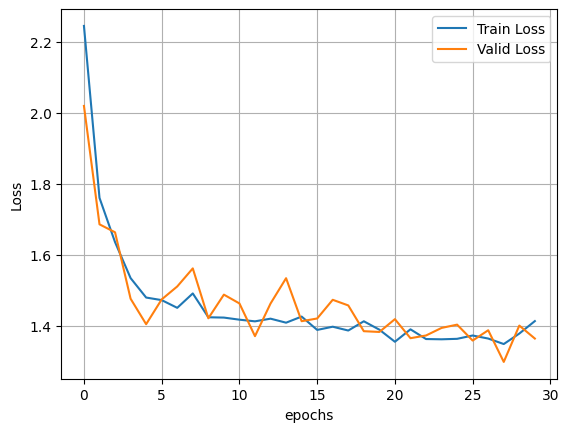

In [23]:
plt.plot( range(history.shape[0]), history["Train Loss"].values, label="Train Loss")
plt.plot( range(history.shape[0]), history["Valid Loss"].values, label="Valid Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

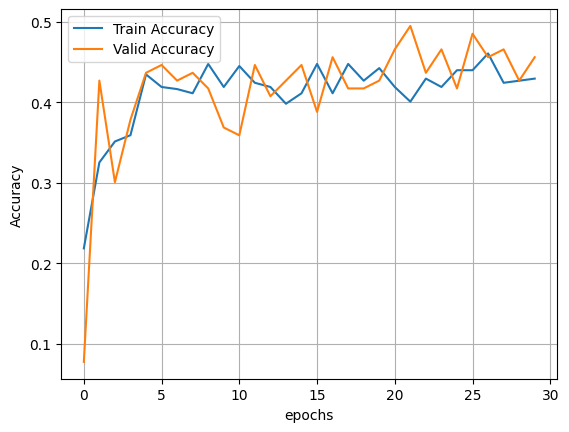

In [24]:
plt.plot( range(history.shape[0]), history["Train Accuracy"].values, label="Train Accuracy")
plt.plot( range(history.shape[0]), history["Valid Accuracy"].values, label="Valid Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()

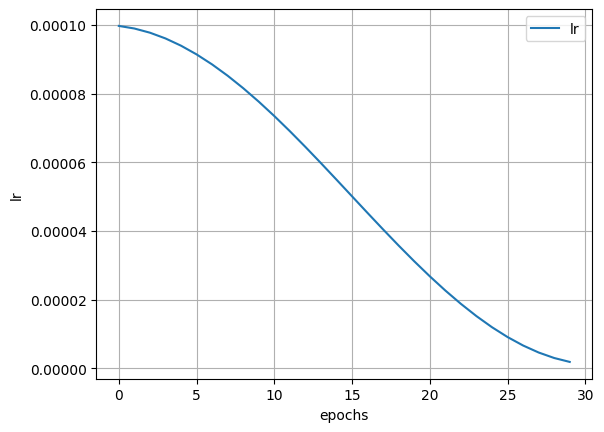

In [25]:
plt.plot( range(history.shape[0]), history["lr"].values, label="lr")
plt.xlabel("epochs")
plt.ylabel("lr")
plt.grid()
plt.legend()
plt.show()